## Homework 05: First Order ODEs
### PHYS420 — Intro to Computational Physics — Fall 2025  
### Hayden Dauphin

<img src="./Images/hw5q1.png" width="700"/>

In [92]:
# --- Dependencies --- 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci 
from scipy.integrate import solve_ivp

In [157]:
# ---- Problem 1: Coding and testing ----

# --- Code 1: Explicit Euler --- 

def explicit_euler(f, timeInterval, initCond, stepSize):
    ''' 
    Function to compute first order ODEs with the explicit Euler method
    Arguments: 
        f: function 
        timeInterval: interval of time to be evaluated over
        initCond: initial condition at start of timeInterval 
        stepSize: size of each step t_{i+1}
    Returns: 
        t_vals: array of time values 
        y_vals: array of solution values at each time value
    '''

    t_start, t_stop = timeInterval  
    num_steps = int((t_stop - t_start) / stepSize)  # divide length of interval by size of steps to get num of steps
    t_vals = np.linspace(t_start, t_stop, num_steps + 1)    # create array of time values 
    y_vals = np.zeros_like(t_vals, dtype=float)  # create array of zeros with length = len(t_vals) and data type = type(t_vals)
    y_vals[0] = initCond    # set initial condition as first y value 

    # --- calculate solutions at each time point with equation for explicit Euler: y_(i+1) = y_i + h * f(t_i, y_i) ---
    for i in range(num_steps):
        y_vals[i+1] = y_vals[i] + stepSize * f(t_vals[i], y_vals[i])
    
    return t_vals, y_vals

# --- Test  ---

# General test function to use:
testfunc = lambda t0, y0: y0 *(1 - y0)
test_exact = 1/(1+ (9 * np.exp(-10)))

# Test explicit euler function
times1, sols1 = explicit_euler(testfunc, (0,10), 0.1, 0.001)
percenterr = (abs((test_exact - sols1[-1])/test_exact)*100)

print(f" --- Explicit Euler test --- \
      \nFinal y = {sols1[-1]:.6e} \
      \nExact = {test_exact:.6e} \
      \nPercent error: {percenterr:.2}%")


 --- Explicit Euler test ---       
Final y = 9.995927e-01       
Exact = 9.995916e-01       
Percent error: 0.00011%


In [158]:
# --- Code 2: RKF45 --- 

# - Fehlberg 4(5) coefficients - 
c = [0, 1/4, 3/8, 12/13, 1, 1/2]
a = [
    [0,0,0,0,0],
    [1/4,0,0,0,0],
    [3/32,9/32,0,0,0],
    [1932/2197,-7200/2197,7296/2197,0,0],
    [439/216,-8,3680/513,-845/4104,0],
    [-8/27,2,-3544/2565,1859/4104,-11/40]
]
# - 4th and 5th order weights -
b5 = [16/135,0,6656/12825,28561/56430,-9/50,2/55]
b4 = [25/216,0,1408/2565,2197/4104,-1/5,0]

def rkf45(f, t0, tf, y0, relTol=1e-8, absTol=1e-10, h=0.01): 
    ''' 
    RKF45 method of solving first order ODEs
    Arguments: 
        f: function 
        t: time interval 
        y0: initial condition 
        relTol: relative tolerance 
        absTol: absolute tolerance 
        h: initial step size 
    Returns: 
        ts: array of the time values solution computed for 
        ys: array of solutions 
        errs: array of error estimates for each accepted step 
        n_accept: number of accepted 
        n_reject: number of rejected steps 
    '''
    # init conditions:
    t = t0 
    y = np.array(y0, dtype=float)   # array to ensure functionality for scalars or systems 
    
    # lists storing results after each accepted step: 
    ts = [t]    # time points 
    ys = [y.copy()]     # solutions 
    errs = [0.0]    # normalized errors
    n_accept = n_reject = 0     # counters for number of accepted/rejected steps 

    # failsafe counter to check for infinite loops 
    max_steps = 100000
    count = 0

    # -- main ADAPTIVE time-stepping loop --
    while t < tf and count < max_steps: 
        if t + h > tf: 
            h = tf - t 
        
        #compute the six RK slopes 
        k1 = f(t, y)
        k2 = f(t + c[1]*h, y + h*a[1][0]*k1)
        k3 = f(t + c[2]*h, y + h*(a[2][0]*k1 + a[2][1]*k2))
        k4 = f(t + c[3]*h, y + h*(a[3][0]*k1 + a[3][1]*k2 + a[3][2]*k3))
        k5 = f(t + c[4]*h, y + h*(a[4][0]*k1 + a[4][1]*k2 + a[4][2]*k3 + a[4][3]*k4))
        k6 = f(t + c[5]*h, y + h*(a[5][0]*k1 + a[5][1]*k2 + a[5][2]*k3 + a[5][3]*k4 + a[5][4]*k5))
        
        # combine the slopes into one array for easy dot product evalutaion 
        Ks = np.array([k1, k2, k3, k4, k5, k6])
        
        # compute the two different order estimates; y5 = 5th order, y4 = 4th order 
        y5 = y + h * np.dot(b5, Ks)
        y4 = y + h * np.dot(b4, Ks)
       
        # diff between estimates and local trunc error
        err = np.linalg.norm(y5 - y4)

        # --- scale error rel to tolerances --- 
        # compute allowed error scale using abs and rel tolerances
        scale = absTol + relTol * np.maximum(np.abs(y), np.abs(y5))

        # normalize the error
        err_norm = err/np.linalg.norm(scale)

        # -- incrememnt step counter (accepted and rejected) --
        count += 1
        
        if err_norm <= 1.0:  # accept step
            t += h  #advance time
            y = y5  #set estimate as new init cond
            ts.append(t) 
            ys.append(y.copy())
            errs.append(err_norm)
            n_accept += 1   #add 1 to number of accepted steps 
        else: # too inaccurate 
            n_reject += 1 #add 1 to number of rejected steps, don't advance 

        # --- Adapt step size for next iteration ---
        # if error is 0 (rare), double the step size
        if err_norm == 0: 
            scaling = 2.0 
        else: # most cases, compute scaling factor based on 5th order exponent (-1/5)
            scaling = 0.9 * err_norm**(-0.2)  # 0.9 to avoid overshoot
        
        # limit how drastically step size can change
        scaling = np.clip(scaling, 0.2, 5.0)

        # update h for next iteration
        h *= scaling 

    # warning that prints out if failsafe trips     
    if count >= max_steps:
        print("Warning: maximum number of steps reached. Integration might be unfinished.")
    
    # convert lists to np.array for easier use 
    return np.array(ts), np.array(ys), np.array(errs), n_accept, n_reject


# test RKF function 
times2, sols2, errEst, acc, rej = rkf45(testfunc, 0, 10, 0.1)
print("\n--- RKF45 Test --- "
      f"\nFinal y = {sols2[-1]:.6f} \
      \nExpected = {test_exact:.6e} \
      \nAccepted = {acc} \
      \nRejected = {rej} \
      \nFinal global err: {abs(sols2[-1]-test_exact):.6e}")


--- RKF45 Test --- 
Final y = 0.999592       
Expected = 9.995916e-01       
Accepted = 56       
Rejected = 3       
Final global err: 2.806174e-09


In [159]:
# --- Code 3: Library Routine ---

# Test scipy solve_ivp 
sols3 = solve_ivp(testfunc, t_span=(0,10), y0=[0.1], method="RK45", rtol=1e-8, atol=1e-10)

print(f" --- Scipy solve_ivp Test --- \
    \nFinal y = {sols3.y[0,-1]:.10e}\
    \nExpected: {test_exact:.10e}\
    \nSteps taken: {len(sols3.t)}\
    \nFinal global err: {abs(sols3.y[0,-1]-test_exact):.2e}")


 --- Scipy solve_ivp Test ---     
Final y = 9.9959156600e-01    
Expected: 9.9959156752e-01    
Steps taken: 51    
Final global err: 1.52e-09


<img src="./Images/hw5q2a.png" width="700px"/>
<img src="./Images/hw5q2b.png" width="700px"/>

In [160]:
''' 
Variable names: 
    T_: time array
    Y_: solution array
    E_: error estimates 
    A_/R_: accepted/rejected counts
    sol_scipy*: scipy object, can access .t and .y for times and solutions 
'''

# Problem 2.1
def f21(t, x):
    return x + np.exp(-t) 

t21 = 1
exact21 = np.sinh(t21) # analytical solution at t=1

# x(0) = 0, t[0, 1]
T_euler21, Y_euler21 = explicit_euler(f21, (0,1), 0, 0.001)
T_rkf21, Y_rkf21, E_rkf21, A_rkf21, R_rkf21 = rkf45(f21, 0, 1, 0)
sol_scipy21 = solve_ivp(f21, (0,1), [0], method="RK45", rtol=1e-8, atol=1e-10)

# Problem 2.2
def f22(t, x):
    return x+2*np.cos(t) 

t22 = 1
exact22 = -np.cos(t22) + np.sin(t22) + 2*np.exp(t22)

# x(0) = 1, t[0, 1]
T_euler22, Y_euler22 = explicit_euler(f22, (0,1), 1, 0.001)
T_rkf22, Y_rkf22, E_rkf22, A_rkf22, R_rkf22 = rkf45(f22, 0, 1, 1)
sol_scipy22 = solve_ivp(f22, (0,1), [1], method="RK45", rtol=1e-8, atol=1e-10)


# Problem 2.3 
def f23(t, x):
    return t*(x**2)

t23 = 1
exact23 = 1/(1-(t23**2/2))

# x(0) = 1, t[0, 1]
T_euler23, Y_euler23 = explicit_euler(f23, (0,1), 1, 0.001)
T_rkf23, Y_rkf23, E_rkf23, A_rkf23, R_rkf23 = rkf45(f23, 0, 1, 1)
sol_scipy23 = solve_ivp(f23, (0,1), [1], method="RK45", rtol=1e-8, atol=1e-10)

# Problem 2.4
def f24(t, x):
    return 1.5*np.sin(2*x) - x*np.cos(t)

# x(0) = 1, t[0, 10]
T_euler24, Y_euler24 = explicit_euler(f24, (0,10), 1, 0.001)
T_rkf24, Y_rkf24, E_rkf24, A_rkf24, R_rkf24 = rkf45(f24, 0, 10, 1)
sol_scipy24 = solve_ivp(f24, (0,10), [1], method="RK45", rtol=1e-8, atol=1e-10)

# Problem 2.5 
def f25(t, x):
    return -0.25*x - x**3 + 1.2*np.sin(t)

# x(0) = 0, t[0,40], default A = 1.2
T_euler25, Y_euler25 = explicit_euler(f25, (0,40), 0, 0.001)
T_rkf25, Y_rkf25, E_rkf25, A_rkf25, R_rkf25 = rkf45(f25, 0, 40, 0)
sol_scipy25 = solve_ivp(f25, (0,40), [0], method="RK45", rtol=1e-8, atol=1e-10)

In [161]:
def compare_solvers(name, y_exact, T_euler, Y_euler, T_rkf, Y_rkf, sol_scipy):
    print(f"\n--- {name} ---")
    print(f"Euler final: {Y_euler[-1]:.6f}")
    print(f"RKF45 final: {Y_rkf[-1]:.6f}")
    print(f"SciPy final: {sol_scipy.y[0, -1]:.6f}")
    print(f"Exact:       {y_exact:.6f}")
    print(f"Euler error: {abs(Y_euler[-1]-y_exact):.3e}")
    print(f"RKF45 error: {abs(Y_rkf[-1]-y_exact):.3e}")
    print(f"SciPy error: {abs(sol_scipy.y[0, -1]-y_exact):.3e}")


compare_solvers("2.1", exact21, T_euler21, Y_euler21, T_rkf21, Y_rkf21, sol_scipy21)
compare_solvers("2.2", exact22, T_euler22, Y_euler22, T_rkf22, Y_rkf22, sol_scipy22)
compare_solvers("2.3", exact23, T_euler23, Y_euler23, T_rkf23, Y_rkf23, sol_scipy23)


--- 2.1 ---
Euler final: 1.174816
RKF45 final: 1.175201
SciPy final: 1.175201
Exact:       1.175201
Euler error: 3.853e-04
RKF45 error: 2.874e-09
SciPy error: 1.786e-09

--- 2.2 ---
Euler final: 5.734596
RKF45 final: 5.737732
SciPy final: 5.737732
Exact:       5.737732
Euler error: 3.136e-03
RKF45 error: 1.605e-08
SciPy error: 8.805e-09

--- 2.3 ---
Euler final: 1.996045
RKF45 final: 2.000000
SciPy final: 2.000000
Exact:       2.000000
Euler error: 3.955e-03
RKF45 error: 1.988e-07
SciPy error: 3.461e-08


In [98]:
def compare_vs_scipy(name, T_e, Y_e, T_r, Y_r, sol):
    ref = sol.y[0,-1]
    print(f"\n--- {name} (vs SciPy) ---")
    print(f"Euler final: {Y_e[-1]:.6f}")
    print(f"RKF45 final: {Y_r[-1]:.6f}")
    print(f"SciPy final: {ref:.6f}")
    print(f"Euler Error: {abs(Y_e[-1]-ref):.3e}")
    print(f"RKF Error: {abs(Y_r[-1]-ref):.3e}")

compare_vs_scipy("2.4", T_euler24, Y_euler24, T_rkf24, Y_rkf24, sol_scipy24)
compare_vs_scipy("2.5", T_euler25, Y_euler25, T_rkf25, Y_rkf25, sol_scipy25)



--- 2.4 (vs SciPy) ---
Euler final: 3.185228
RKF45 final: 3.187899
SciPy final: 3.187898
Euler Error: 2.670e-03
RKF Error: 7.222e-07

--- 2.5 (vs SciPy) ---
Euler final: 0.883782
RKF45 final: 0.883623
SciPy final: 0.883623
Euler Error: 1.585e-04
RKF Error: 4.099e-09


In [99]:
# -- Test multiple step sizes to compare error for euler --

def step_size_comparison(f, interval, y0, h_vals, tf_exact):
    ''' 
    Run explicit_euler for the step sizes in h_vals to gather corresponding errors
    Arguments: 
        f: function 
        interval: time interval to calculate for 
        y0: init condition
        h_vals (array): step sizes to calculate with 
        tf_exact: exact numerical solution to function to compare solutions to 
    Returns: 
        errors: list of errors for each h value displayed in rows
    '''
    t0, tf = interval 
    errors = []
    for h in h_vals:
        T, Y = explicit_euler(f, interval, y0, h)
        y_num = Y[-1]
        y_ex = tf_exact
        err = abs(y_num - y_ex)
        errors.append((h, y_num, y_ex, err, err/max(abs(y_ex), 1e-15)))
    return errors

def print_table(errors, ex_num):
    ''' 
    function to print out a table of the results from step_size_comparison 
    Arguments: 
        errors: list returned by step_size_comparison 
        ex_num (string): which ODE number is being checked (e.g. "2.1", "2.2", etc.)
    '''
    print("\nError vs. Step Size (Explicit Euler): ODE " + ex_num)
    print(f"{'h':>10} {'y(tf)':>14} {'exact':>14} {'abs err':>14} {'relative err':>14}")
    print("-"*70)
    for h, y_num, y_ex, e, r in errors:
        print(f"{h:10.5g} {y_num:14.6f} {y_ex:14.6f} {e:14.3e} {r:14.3e}")

h_list = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625] #step sizes each half the size of the last index 
errors21 = step_size_comparison(f21, (0,1), 0, h_list, exact21)
print_table(errors21, "2.1")

errors22 = step_size_comparison(f22, (0,1), 1, h_list, exact22)
print_table(errors22, "2.2")

errors23 = step_size_comparison(f23, (0,1), 1, h_list, exact23)
print_table(errors23, "2.3")


Error vs. Step Size (Explicit Euler): ODE 2.1
         h          y(tf)          exact        abs err   relative err
----------------------------------------------------------------------
       0.1       1.140517       1.175201      3.468e-02      2.951e-02
      0.05       1.156933       1.175201      1.827e-02      1.554e-02
     0.025       1.165818       1.175201      9.383e-03      7.984e-03
    0.0125       1.170445       1.175201      4.756e-03      4.047e-03
   0.00625       1.172807       1.175201      2.394e-03      2.037e-03
  0.003125       1.174000       1.175201      1.201e-03      1.022e-03
 0.0015625       1.174599       1.175201      6.017e-04      5.120e-04

Error vs. Step Size (Explicit Euler): ODE 2.2
         h          y(tf)          exact        abs err   relative err
----------------------------------------------------------------------
       0.1       5.448413       5.737732      2.893e-01      5.042e-02
      0.05       5.587201       5.737732      1.505e-0

<img src="./Images/hw5q4.png" width="700px"/>

Method          Final T (C)       Abs Error          Rel Error
--------------------------------------------------------------
Euler           62.45661545      5.307287e-04        8.497e-04
RKF45           62.45714607      1.108750e-07        1.775e-07
Scipy RK45      62.45714624      6.131692e-08        9.817e-08
Analytical      62.45714618            -                 -


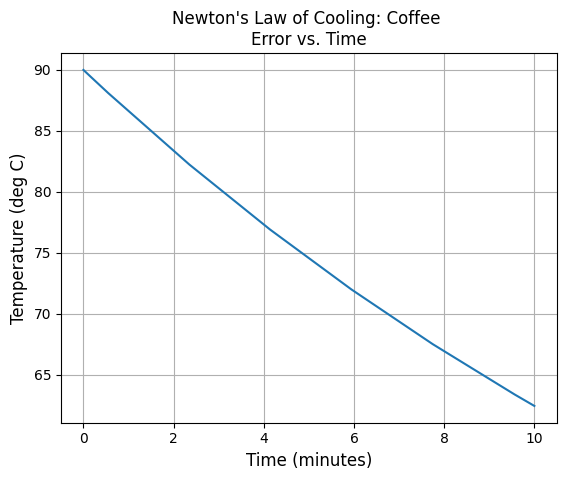

In [243]:
# ---- Part 4: Physics I —— Newton's Law of Cooling ----

# -- Define formula where heat transfer coeff k = 0.05 min^-1 and room temp is 20 C --
def cooling(t, T, TM=20, k=0.05):
    return -k * (T - TM)

# -- Define analytical solution to compute exact numerical solution --
def exact_cooling(t, T0, TM=20, k=0.05):
    return TM + (T0 - TM) * np.exp(-k * t)

# --- Compute temperature of coffee (init = 90 C) after 10 min ---
# T_* = time array, Y_* = solutions array 
T_eulerCoffee, Y_eulerCoffee = explicit_euler(cooling, (0,10), 90, 0.001)
T_rkfCoffee, Y_rkfCoffee, *others = rkf45(cooling, 0, 10, 90)
scipyCoffee = solve_ivp(cooling, (0,10), [90], method="RK45", rtol=1e-8, atol=1e-10)

# -- Exact values -- 
T_coffee_exact = exact_cooling(T_rkfCoffee, 90)

# --- Plot cooling curve and print table of the final values from each diff method --- 

# -- Plot --
fig, ax = plt.subplots()
ax.set_title("Newton's Law of Cooling: Coffee \nError vs. Time")
ax.set_xlabel("Time (minutes)", fontsize=12)
ax.set_ylabel("Temperature (deg C)", fontsize=12)
ax.plot(T_rkfCoffee, T_coffee_exact)
ax.grid(True)
#plt.show()

# -- Table --

methods = {
    "Euler": Y_eulerCoffee[-1],
    "RKF45": Y_rkfCoffee[-1],
    "Scipy RK45": scipyCoffee.y[0,-1],
    "Analytical": T_coffee_exact[-1]
}

exact = methods["Analytical"]
print(f"{'Method':<12}{'Final T (C)':>15}{'Abs Error':>16}{'Rel Error':>19}")
print("-"*62)
for name, val in methods.items():
    if name != "Analytical":
        abs_err = abs(val-exact)
        rel_err = abs_err/exact * 100 
        print(f"{name:<12}{val:>15.8f}{abs_err:>18.6e}{rel_err:>17.3e}")
    else:
        print(f"{name:<12}{val:>15.8f}{'-':>13.6}{'-':>18.3}")